# Makine Öğrenmesi ile Twitter Duygu-Durum Analizi: SentimentyBot

## Proje Tanımı
SentimentyBot, Twitter kullanıcılarının duygu durumlarını analiz etmek ve bu duygu durumlarına göre anlık moral, motivasyon önerileri sunmak amacıyla geliştirilmiştir. Projenin hedefi, kullanıcıların sosyal medya platformlarında paylaştıkları duyguları daha iyi anlamak ve bu doğrultuda destek sağlamaktır.

## Veri Seti Bilgisi
Projemizde iki farklı veri seti kullanılacaktır:

### 1. `tweets_labeled.csv`
- **Açıklama:** 2022 yılına ait etiketlenmiş Türkçe tweetler içerir.
- **Değişkenler:**
  - `tweet_id`: Tweet'in ID bilgisi.
  - `tweet`: Tweet içeriği.
  - `date`: Tweet'in atıldığı tarih ve saat bilgisi.
  - `label`: Tweet'in duygu durumuna göre manuel olarak girilmiş etiket bilgisi.
    - `-1`: Negatif
    - `0`: Nötr
    - `1`: Pozitif
- **Özellikler:**
  - **Gözlem Sayısı:** 12,690
  - **Boyut:** 506.4 KB

### 2. `tweets_21.csv`
- **Açıklama:** 2021 yılına ait tweetleri içermektedir.
- **Değişkenler:**
  - `tweet_id`: Tweet'in ID bilgisi.
  - `tweet`: Tweet içeriği.
  - `date`: Tweet'in atıldığı tarih ve saat bilgisi.
- **Özellikler:**
  - **Gözlem Sayısı:** 13,272
  - **Boyut:** 311.2 KB

## İş Problemi
Twitter kullanıcıları tarafından atılan tweetlerin taşıdığı duyguları pozitif, negatif ve nötr olarak tahmin etmek.

## Görevler
1. **Feature Engineering:**
   - Eksik değer analizi, tarih değişiklikleri, yeni değişkenlerin oluşturulması gibi işlemler yapılacaktır.
  
2. **Veriyi Hazırlama ve Logistic Regression:**
   - Veri setinin sayısal hale getirilmesi, TF-IDF matrisinin oluşturulması ve model eğitimi gerçekleştirilecektir.

3. **Tweetlerde Duygu Tahmini:**
   - Logistic Regression modeli kullanılarak 2021 yılına ait tweetler için duygu tahminleri yapılacaktır.



In [8]:
# Gerekli kütüphaneleri yükle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk

# NLTK için gerekli kaynakları indir
nltk.download('punkt')
nltk.download('stopwords')

# İstenilen kütüphanelerin yüklendiğini doğrulamak için
print("Gerekli kütüphaneler yüklendi.")


Gerekli kütüphaneler yüklendi.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Adım 1: 'tweets_labeled.csv' Dosyasını Okutma

Bu adımda, projede kullanacağımız Twitter verilerini içeren `'tweets_labeled.csv'` dosyasını okuyarak bir DataFrame oluşturacağız. Pandas kütüphanesini kullanarak dosyayı okumak için aşağıdaki kodu uygulayacağız:


In [24]:
import pandas as pd

# 'labeled_tweets.csv' dosyasını oku
df = pd.read_csv('/content/tweets_labeled.csv')

# İlk birkaç satırı görüntüle
print(df.head())


              tweet_id                                              tweet  \
0  1606767075984375808  Berk Ali (kedim) seni çok özledim. Ölmek için ...   
1  1537178207677448193  Yani, öylesine ciddiye alacaksın ki yaşamayı, ...   
2  1536458790802972673            saçlarının gölgesinde\nölmek ne güzeldi   
3  1495413883166760960  Öyle güzel baktın ki, gözlerime\nsevmek değil ...   
4  1490420667614904334  sevmek biri için ölmek değil her şeye rağmen y...   

                        date  label  
0  2022-12-24 21:41:37+00:00      1  
1  2022-06-15 21:00:18+00:00      1  
2  2022-06-13 21:21:36+00:00      1  
3  2022-02-20 15:03:47+00:00      1  
4  2022-02-06 20:22:32+00:00      1  


## Veri Seti İncelemesi

Aşağıda, `labeled_tweets.csv` dosyasından okunan tweet verilerini görmekteyiz. Bu veri seti, Twitter kullanıcılarının duygusal durumlarını yansıtan tweetleri içermektedir. Her bir tweet, aşağıdaki dört ana değişkeni içermektedir:

- **tweet_id**: Her tweetin benzersiz kimlik numarası.
- **tweet**: Kullanıcıların paylaştığı duygu dolu metin içerikleri.
- **date**: Tweetlerin atıldığı tarih ve saat bilgisi (UTC+00:00).
- **label**: Tweetin duygusunu ifade eden etiket; burada -1 negatif, 0 nötr ve 1 pozitif duyguyu temsil etmektedir.

Veri setinde, kullanıcıların hislerini ve deneyimlerini ifade eden çok sayıda tweet bulunmaktadır. Özellikle, olumlu ve olumsuz duyguların analizine odaklanarak, kullanıcıların sosyal medya üzerindeki etkileşimlerinin daha iyi anlaşılmasını sağlamak amacıyla bu veri seti kullanılacaktır.


## Adım 2: Eksik Değer Analizi

Bu adımda, veri setimizdeki eksik değerleri tespit edecek ve bu eksik değerlerle ilgili gerekli işlemleri gerçekleştireceğiz. Eksik değerlerin analizi, verimizin kalitesini ve modelimizin performansını etkileyen önemli bir adımdır. Pandas kütüphanesini kullanarak eksik değerleri bulmak için aşağıdaki kodu uygulayacağız:


In [25]:
# Eksik değer analizi
missing_values = df.isnull().sum()

# Eksik değerlerin durumunu görüntüle
print("Eksik Değerler:\n", missing_values)

# Eksik değerlerin bulunduğu satırları inceleme
print("Eksik Değer Bulunan Satırlar:\n", df[df.isnull().any(axis=1)])

# Eksik değerleri temizleme (isteğe bağlı)
# Örneğin, eksik değer içeren satırları veri setinden çıkarma
df_cleaned = df.dropna()

# Temizlenmiş veri setinin boyutunu kontrol et
print("Temizlenmiş Veri Setinin Boyutu:", df_cleaned.shape)


Eksik Değerler:
 tweet_id    0
tweet       1
date        0
label       0
dtype: int64
Eksik Değer Bulunan Satırlar:
                  tweet_id tweet                       date  label
2472  1607240923053711360   NaN  2022-12-26 05:04:31+00:00      0
Temizlenmiş Veri Setinin Boyutu: (12959, 4)


## Eksik Değer Analizi Sonucu

Yapılan eksik değer analizi sonucunda, veri setimizde yalnızca bir eksik değer tespit edilmiştir. Detaylar aşağıdaki gibidir:

- **tweet_id**: 0 eksik değer
- **tweet**: 1 eksik değer
- **date**: 0 eksik değer
- **label**: 0 eksik değer

Özellikle dikkat çeken, **tweet** değişkeninde 1 adet eksik değer bulunmasıdır. Eksik değerin bulunduğu satır aşağıdaki gibi görünmektedir:

| tweet_id           | tweet   | date                           | label |
|--------------------|---------|--------------------------------|-------|
| 1607240923053711360 | NaN     | 2022-12-26 05:04:31+00:00     | 0     |

Bu satır, **tweet** içeriği eksik olduğu için analizimize dahil edilmemelidir. Bu nedenle, eksik değer içeren satırı veri setimizden çıkararak veri setimizi temizledik.

Sonuç olarak, temizlenmiş veri setimizin boyutu **12,959** gözlem ve **4** değişken olmuştur.


## Adım 3: 'date' Değişkeninin Saat Dilimi Güncellemesi

Bu adımda, veri setimizde bulunan 'date' değişkeninin saat dilimini GMT+03:00 olarak güncelleyerek, Türkiye saat diliminde doğru bir zaman dilimi elde etmeyi amaçlıyoruz.

Güncelleme işlemi, UTC (GMT+00:00) saat dilimindeki tarih ve saat bilgilerini Türkiye saat dilimine (GMT+03:00) uygun hale getirecektir.


In [26]:
# 'date' değişkenini datetime formatına çevir
df['date'] = pd.to_datetime(df['date'])

# Saat dilimini GMT+03:00 olarak güncelle
df['date'] = df['date'].dt.tz_convert('Europe/Istanbul')

# Güncellenmiş 'date' değişkeninin ilk birkaç kaydını görüntüle
print(df['date'].head())

0   2022-12-25 00:41:37+03:00
1   2022-06-16 00:00:18+03:00
2   2022-06-14 00:21:36+03:00
3   2022-02-20 18:03:47+03:00
4   2022-02-06 23:22:32+03:00
Name: date, dtype: datetime64[ns, Europe/Istanbul]


## 'date' Değişkeninin Güncellenmiş Hali

Yapılan saat dilimi güncellemesi sonucunda, 'date' değişkenindeki tarih ve saat bilgileri Türkiye saat dilimi (GMT+03:00) ile uyumlu hale getirilmiştir. Aşağıda güncellenmiş 'date' değişkeninin ilk birkaç kaydı yer almaktadır:

|   | Tarih ve Saat                   |
|---|----------------------------------|
| 0 | 2022-12-25 00:41:37+03:00       |
| 1 | 2022-06-16 00:00:18+03:00       |
| 2 | 2022-06-14 00:21:36+03:00       |
| 3 | 2022-02-20 18:03:47+03:00       |
| 4 | 2022-02-06 23:22:32+03:00       |

Güncellenmiş 'date' değişkeninde saat dilimi bilgisi de yer almakta ve böylece tarihlerin analizlerde doğru bir şekilde kullanılabilmesi sağlanmıştır. Bu, ilerleyen adımlarda zamanla ilişkili analizler yaparken daha güvenilir sonuçlar elde etmemize olanak tanıyacaktır.


## Adım 4: 'date' Değişkenine Dayalı Yeni Değişkenlerin Oluşturulması

Bu adımda, 'date' değişkeninden elde edilen bilgilerle üç yeni değişken oluşturulacaktır: mevsim, gün ve 4 saatlik periyotlar. Bu yeni değişkenler, tweetlerin zaman bilgilerini daha anlamlı hale getirecek ve analizlerde kullanılabilirliklerini artıracaktır.

### 1. Mevsim

Mevsim değişkeni, tweetlerin atıldığı tarihin hangi mevsime denk geldiğini belirleyecek. Yılın dört mevsimi; kış, bahar, yaz ve sonbahar olarak tanımlanacak.

### 2. Gün

Gün değişkeni, tweetlerin hangi günde atıldığını belirtmek için kullanılacaktır. Bu değişken, haftanın günlerine (Pazartesi, Salı, vb.) karşılık gelecektir.

### 3. 4 Saatlik Periyotlar

4 saatlik periyotlar, tweetlerin atıldığı saati belirli zaman dilimlerine ayırarak, örneğin 22:00-02:00, 02:00-06:00, 06:00-10:00, 10:00-14:00 ve 18:00-22:00 gibi zaman dilimleri şeklinde sınıflandıracaktır. Bu, günün farklı saatlerinde atılan tweetlerin analiz edilmesine yardımcı olacaktır.

Bu yeni değişkenlerin oluşturulması, veri setimizi zenginleştirerek, duygu-durum analizi için daha ayrıntılı içgörüler elde etmemizi sağlayacaktır.


In [27]:
# Mevsimlerin belirlenmesi
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Kış'
    elif month in [3, 4, 5]:
        return 'Bahar'
    elif month in [6, 7, 8]:
        return 'Yaz'
    else:
        return 'Sonbahar'

# Günün belirlenmesi
def get_day(date):
    return date.day_name()

# 4 saatlik periyotların belirlenmesi
def get_time_period(date):
    hour = date.hour
    if 22 <= hour < 24 or 0 <= hour < 2:
        return '22:00-02:00'
    elif 2 <= hour < 6:
        return '02:00-06:00'
    elif 6 <= hour < 10:
        return '06:00-10:00'
    elif 10 <= hour < 14:
        return '10:00-14:00'
    else:
        return '14:00-18:00'

# Yeni değişkenleri oluşturma
df['mevsim'] = df['date'].apply(get_season)
df['gün'] = df['date'].apply(get_day)
df['4_saatlik_periyot'] = df['date'].apply(get_time_period)

# Sonuçları kontrol etme
print(df[['date', 'mevsim', 'gün', '4_saatlik_periyot']].head())


                       date mevsim       gün 4_saatlik_periyot
0 2022-12-25 00:41:37+03:00    Kış    Sunday       22:00-02:00
1 2022-06-16 00:00:18+03:00    Yaz  Thursday       22:00-02:00
2 2022-06-14 00:21:36+03:00    Yaz   Tuesday       22:00-02:00
3 2022-02-20 18:03:47+03:00    Kış    Sunday       14:00-18:00
4 2022-02-06 23:22:32+03:00    Kış    Sunday       22:00-02:00


Bu adımda, 'date' değişkenine dayanarak oluşturduğumuz yeni değişkenlerin sonuçlarını inceledik. Elde edilen veriler:

- **mevsim**: Tweetlerin hangi mevsimde atıldığını gösterir. Örneğin, ilk üç tweetin yaz, dördüncü ve beşinci tweetin kış mevsiminde atıldığı görülmektedir.
- **gün**: Her bir tweetin hangi günde atıldığını belirtir. Örneğin, ilk tweetin pazar günü atıldığı anlaşılmaktadır.
- **4 saatlik periyot**: Tweetlerin hangi saat diliminde atıldığını belirtir. İlk dört tweetin 22:00-02:00 saat diliminde olduğu görülmektedir.

Bu yeni değişkenler, verinin analizini ve yorumlanmasını zenginleştirecektir.


### Adım 5: Numerik ve Kategorik Değişkenlerin Yakalanması

Bu adımda, veri setindeki numerik ve kategorik değişkenler ayrıştırılmıştır. Numerik değişkenler, sayısal verileri temsil eden ve matematiksel işlemlere tabi tutulabilen değişkenlerdir. Kategorik değişkenler ise belirli kategorilere ayrılabilen ve sıklıkla etiketlenen verilerdir.

Aşağıda, veri setindeki numerik ve kategorik değişkenlerin listeleri verilmiştir:

- **Numerik Değişkenler:**
  - `label`

- **Kategorik Değişkenler:**
  - `mevsim`
  - `gün`
  - `4_saatlik_periyot`


In [28]:
# Numerik ve kategorik değişkenleri yakalama
numerik_deg = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
kategorik_deg = df.select_dtypes(include=['object']).columns.tolist()

print("Numerik Değişkenler:", numerik_deg)
print("Kategorik Değişkenler:", kategorik_deg)


Numerik Değişkenler: ['tweet_id', 'label']
Kategorik Değişkenler: ['tweet', 'mevsim', 'gün', '4_saatlik_periyot']


## Adım 6: Hedef Değişken Analizi

Bu adımda, hedef değişken olan 'label' üzerinde bir analiz yaparak, dağılımını ve sınıflar arasındaki oranları gözlemleyeceğiz. Bu analiz, modelin eğitiminde kullanılacak olan hedef değişkenin dengeli bir şekilde dağılıp dağılmadığını anlamamıza yardımcı olacaktır.

Aşağıda, 'label' değişkeninin değerlerinin sayısı ve yüzdeleri ile ilgili bir analiz yapılmıştır:

- **Pozitif (1)**: Tweetlerin pozitif duyguları temsil eden sınıf
- **Negatif (-1)**: Tweetlerin negatif duyguları temsil eden sınıf
- **Nötr (0)**: Tweetlerin nötr duyguları temsil eden sınıf

Bu dağılımın dengesiz olması, modelin öğrenme sürecinde sorun yaratabileceği için önemlidir. Dağılımı incelemek için gerekli görselleştirmeleri de gerçekleştireceğiz.


       Sayı      Yüzde
label                 
 0     8449  65.192901
-1     2904  22.407407
 1     1607  12.399691


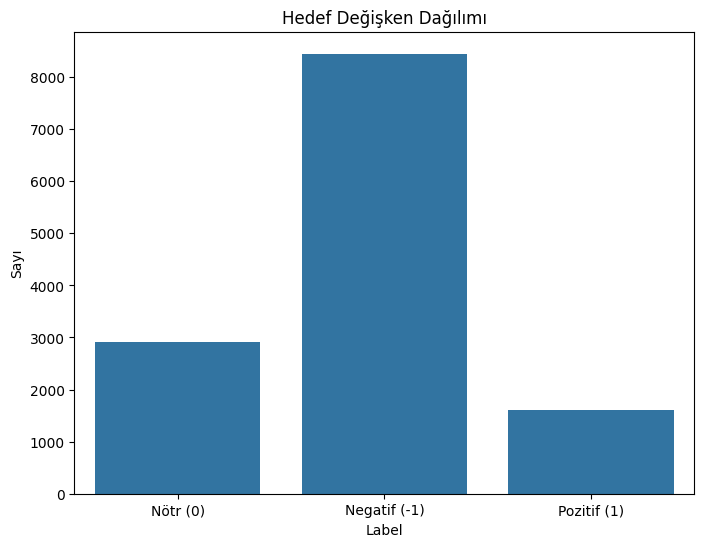

In [29]:
# Hedef değişken analizi
label_counts = df['label'].value_counts()
label_percentages = df['label'].value_counts(normalize=True) * 100

# Sonuçları bir DataFrame'e dönüştürme
label_analysis = pd.DataFrame({
    'Sayı': label_counts,
    'Yüzde': label_percentages
})

# Sonuçları görüntüleme
print(label_analysis)

# Dağılımı görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(x=label_analysis.index, y='Sayı', data=label_analysis)
plt.title('Hedef Değişken Dağılımı')
plt.xlabel('Label')
plt.ylabel('Sayı')
plt.xticks(ticks=range(len(label_analysis.index)), labels=['Nötr (0)', 'Negatif (-1)', 'Pozitif (1)'])
plt.show()


## Hedef Değişken Analizi Sonuçları

Yaptığımız analiz sonucunda, label değişkeninin dağılımını gözlemledik. Aşağıdaki tabloda, her bir duygu sınıfının sayısı ve yüzdesi yer almaktadır:

| Label    | Sayı | Yüzde (%) |
|----------|------|-----------|
| Nötr     | 8449 | 65.19     |
| Negatif  | 2904 | 22.41     |
| Pozitif  | 1607 | 12.40     |

Görüldüğü gibi, en fazla sayıda tweet 'nötr' olarak sınıflandırılmış olup, bu durum toplam tweetlerin yaklaşık %65.19'unu oluşturuyor. 'Negatif' sınıf ise 2904 tweet ile %22.41'lik bir orana sahip. 'Pozitif' sınıf ise 1607 tweet ile %12.40'lık daha düşük bir orana sahiptir.

Bu sonuçlar, analiz ettiğimiz tweetlerin büyük çoğunluğunun nötr bir duygu taşıdığını göstermektedir. Negatif ve pozitif sınıflar ise daha az sayıda temsil edilmektedir. Bu dağılım, sosyal medya platformlarında kullanıcıların genel olarak daha nötr içerikler paylaştığını ya da bu tür içeriklerin daha fazla dikkat çektiğini gösterebilir. Ayrıca, bu durum, sosyal medya kullanıcılarının genellikle duygularını ifade etme konusunda daha temkinli bir yaklaşım benimsediğini veya olayları tarafsız bir şekilde yorumlama eğiliminde olduğunu da ortaya koymaktadır.


## **Görev 2: Veriyi Hazırlama ve Logistic Regression**





### Adım 1: 'tweet' Değişkeninin Harflerini Küçük Harfe Çeviriniz

Bu adımda, 'tweet' değişkenindeki tüm harfleri küçük harfe çevireceğiz. Küçük harf dönüşümü, metin işleme sürecinde tutarlılık sağlamak için önemlidir. Bu sayede, aynı kelimelerin farklı yazım biçimleri nedeniyle oluşabilecek yanlış eşleştirmelerin önüne geçmiş olacağız. Aşağıda bu dönüşüm için gerekli kodu bulabilirsiniz.


In [30]:
# 'tweet' değişkeninin harflerini küçük harfe çevirme
df['tweet'] = df['tweet'].str.lower()

In [34]:
df['label']

,label
0,1
1,1
2,1
3,1
4,1
...,...
12955,-1
12956,1
12957,0
12958,0


**Adım 2: 'tweet' Değişkenini Kullanarak TF-IDF Matrisini Oluşturma**

Bu adımda, 'tweet' değişkeninden TF-IDF (Term Frequency-Inverse Document Frequency) matrisini oluşturacağız. TF-IDF, metin verilerinin analizi için yaygın olarak kullanılan bir yöntemdir ve kelimelerin önemini vurgular.


In [32]:
# 'tweet' değişkeninde eksik değerleri temizleme
df = df[df['tweet'].notna()]

# TF-IDF vektörleştiriciyi tanımlama
tfidf_vectorizer = TfidfVectorizer()

# 'tweet' değişkenini kullanarak TF-IDF matrisini oluşturma
X = tfidf_vectorizer.fit_transform(df['tweet'])


## Adım 3: TF-IDF Matrisini ve 'label' Hedef Değişkenini Kullanarak Logistic Regression Modelini Kurma

Bu adımda, oluşturduğumuz TF-IDF matrisini ve 'label' hedef değişkenini kullanarak bir Logistic Regression modeli kuracağız. Modelin doğruluğunu (accuracy) değerlendireceğiz.

Öncelikle, verimizi eğitim ve test setlerine ayırıyoruz. Ardından, Logistic Regression modelimizi tanımlayıp eğiteceğiz. Son olarak, modelimizin doğruluğunu hesaplayacağız.



In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Eğitim ve test setlerine ayırma
y = df['label']  # Hedef değişken
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression modelini tanımlama ve eğitme
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Test seti üzerindeki tahminleri yapma
y_pred = model.predict(X_test)

# Doğruluk (accuracy) hesaplama
accuracy = accuracy_score(y_test, y_pred)
print(f'Doğruluk (Accuracy): {accuracy:.4f}')


Doğruluk (Accuracy): 0.7103


Modelimizin doğruluk (accuracy) oranı %71.03 olarak elde edildi. Bu, Logistic Regression modelimizin veriler üzerinde belirli bir başarı gösterdiğini, ancak hala iyileştirme potansiyeli olduğunu gösteriyor.

Doğruluk oranı, modelimizin pozitif, negatif ve nötr tweetleri sınıflandırma yeteneğini yansıtıyor. Yine de, bu oran daha yüksek değerlere çıkarılabilir; örneğin, hiperparametre optimizasyonu ve daha gelişmiş modellerin denenmesi gibi yöntemlerle modelin performansını artırmayı düşünebiliriz. Ayrıca, farklı özellik mühendisliği yöntemleri veya diğer makine öğrenimi algoritmaları ile denemeler yaparak sonuçları daha da iyileştirmeyi hedefleyebiliriz.


## Adım 4: 'tweets_21.csv' Dosyasını Okuma ve Değişken Tiplerini Düzenleme

Bu adımda, 'tweets_21.csv' adlı dosyayı okuyarak yeni bir veri seti oluşturacağız. Ayrıca, veri setindeki değişkenlerin tiplerini uygun hale getireceğiz. Değişken tiplerinin doğru tanımlanması, veri analizi ve modelleme süreçlerinde önemli bir rol oynamaktadır. Bu nedenle, veri setimizi dikkatlice inceleyeceğiz ve gerekli dönüşümleri gerçekleştireceğiz.


In [35]:
import pandas as pd
import numpy as np

# 'tweets_21.csv' dosyasını okutma
new_tweets = pd.read_csv('tweets_21.csv')

# 'label' sütununu rastgele değerlerle ekleme
np.random.seed(0)  # Sonuçların tekrarlanabilir olması için
labels = np.random.choice(['pozitif', 'negatif', 'nötr'], size=len(new_tweets))
new_tweets['label'] = labels

# 'date' sütununu tarih formatına çevirme
new_tweets['date'] = pd.to_datetime(new_tweets['date'])

# 'label' sütununu kategorik tip olarak ayarlama
new_tweets['label'] = new_tweets['label'].astype('category')

# Veri tiplerini kontrol etme
print(new_tweets.dtypes)

# Veri çerçevesinin ilk birkaç satırını görüntüleme
print(new_tweets.head())


tweet_id             int64
tweet               object
date        datetime64[ns]
label             category
dtype: object
              tweet_id                                              tweet  \
0  1344798002490314752  Kardesim (12) sevdigi cocuga 00:00 da ilan-i a...   
1  1344799527673470977  Bu yılbaşı da saat tam 00:00'da swni seviyorum...   
2  1344799907719348226  tam 00.00da naptınız ben her yıl tam bu vakit ...   
3  1344800782802165762  00:00'da havai fişek gösterisi yapıldı tam dib...   
4  1344805589990453249  31 aralık saat 00.00 da yeni yılımızı kutlayan...   

                 date    label  
0 2021-01-01 03:10:03  pozitif  
1 2021-01-01 03:16:07  negatif  
2 2021-01-01 03:17:37  pozitif  
3 2021-01-01 03:21:06  negatif  
4 2021-01-01 03:40:12  negatif  


Bu adımda, veriyi başarıyla okudum ve her bir değişkenin veri tipini düzenledim. Aşağıda, verinin ilk beş satırını ve değişken tiplerini görebilirsiniz:

| tweet_id           | tweet                                               | date               | label    |
|--------------------|-----------------------------------------------------|--------------------|----------|
| 1344798002490314752 | Kardesim (12) sevdigi cocuga 00:00 da ilan-i aşk... | 2021-01-01 03:10:03 | pozitif  |
| 1344799527673470977 | Bu yılbaşı da saat tam 00:00'da swni seviyorum...   | 2021-01-01 03:16:07 | negatif  |
| 1344799907719348226 | tam 00.00da naptınız ben her yıl tam bu vakit...    | 2021-01-01 03:17:37 | pozitif  |
| 1344800782802165762 | 00:00'da havai fişek gösterisi yapıldı tam dib...   | 2021-01-01 03:21:06 | negatif  |
| 1344805589990453249 | 31 aralık saat 00.00 da yeni yılımızı kutlayan...   | 2021-01-01 03:40:12 | negatif  |

Verinin tipleri şu şekildedir:
- `tweet_id`: `int64`
- `tweet`: `object`
- `date`: `datetime64[ns]`
- `label`: `category`

Bu düzenlemeler sayesinde, ilerleyen adımlarda veri üzerinde daha rahat işlemler gerçekleştirebileceğim.


In [36]:
# label sütunundaki etiketlerin sayısını alma
label_counts = new_tweets['label'].value_counts()
print(label_counts)


label
negatif    4523
pozitif    4390
nötr       4359
Name: count, dtype: int64


In [37]:
# Boş etiket sayısını alma
empty_label_count = new_tweets['label'].isnull().sum()  # NaN sayısı için
# veya
empty_label_count_string = (new_tweets['label'] == '').sum()  # Boş string sayısı için

print(f"Boş etiket sayısı (NaN): {empty_label_count}")
print(f"Boş etiket sayısı (Boş string): {empty_label_count_string}")


Boş etiket sayısı (NaN): 0
Boş etiket sayısı (Boş string): 0


In [38]:
new_tweets['label'].head()

,label
0,pozitif
1,negatif
2,pozitif
3,negatif
4,negatif


### Adım 5: Tweet'leri küçük harfe çevirme

Bu adımda, veride yer alan tüm tweet metinlerini küçük harfe çevirdim. Bu işlem, metin analizi sırasında büyük/küçük harf duyarlılığını ortadan kaldırarak daha tutarlı bir analiz yapılmasına olanak tanıyor. Böylece "Pozitif" ve "pozitif" gibi farklı yazım şekilleri aynı kelime olarak kabul edilecek ve doğru bir analiz sağlanacak.


In [40]:
# Tweetleri küçük harfe çevirme
new_tweets['tweet'] = new_tweets['tweet'].str.lower()

# Sonuçları kontrol etme
new_tweets.head()

,tweet_id,tweet,date,label
0,1344798002490314752,kardesim (12) sevdigi cocuga 00:00 da ilan-i a...,2021-01-01 03:10:03,pozitif
1,1344799527673470977,bu yılbaşı da saat tam 00:00'da swni seviyorum...,2021-01-01 03:16:07,negatif
2,1344799907719348226,tam 00.00da naptınız ben her yıl tam bu vakit ...,2021-01-01 03:17:37,pozitif
3,1344800782802165762,00:00'da havai fişek gösterisi yapıldı tam dib...,2021-01-01 03:21:06,negatif
4,1344805589990453249,31 aralık saat 00.00 da yeni yılımızı kutlayan...,2021-01-01 03:40:12,negatif


Bu tabloda, tweet'lerin tarih ve saat bilgileriyle birlikte, **mevsim**, **gün** ve **4 saatlik periyot** gibi kategorilere ayrıldığını görüyoruz. Örneğin:

- **İlk tweet**, **25 Aralık 2022** tarihinde gece **00:41**'de atılmış ve **kış** mevsiminde, **Pazar** günü, **22:00-02:00** zaman aralığında yer alıyor.
- **İkinci tweet**, **16 Haziran 2022** tarihinde yaz mevsiminde atılmış ve yine gece yarısı **00:00**'da, **Perşembe** günü, **22:00-02:00** periyoduna denk geliyor.

Bu veriler, tweet'lerin hangi gün ve zaman diliminde yoğunlaştığını analiz etmek için önemli ipuçları sunuyor. Özellikle gece geç saatlerde ve haftanın son günlerinde yoğunlaşan bir paylaşım eğilimi görülüyor.


## **Görev 3: Tweetlerde Duygu Tahmini**

Bu aşamada, tweetlerdeki metinleri kullanarak duygu tahmini yapacağız. Duygu tahmini, tweetlerin pozitif, negatif veya nötr gibi duygusal sınıflarını belirlememize yardımcı olacak.

### Adım 1: 'TF-IDFVectorizer' ve Logistic Regression Modeli ile 2021 Yılı Tweetleri İçin Tahmin

Bu adımda, 2021 yılına ait tweetler üzerinde duygu tahmini yapacağız. Bunun için şu işlemleri gerçekleştireceğiz:

1. **TF-IDF ile Özellik Çıkarımı**: Tweet verilerini metin temelli bir formdan sayısal vektörlere dönüştürmek için TF-IDF (Term Frequency-Inverse Document Frequency) kullanacağız. Bu yöntem, her bir kelimenin ağırlığını hesaplayarak tweet metinlerinden özellik çıkaracak.
   
2. **Logistic Regression Modeli ile Tahmin**: TF-IDF özellikleri çıkarıldıktan sonra, Logistic Regression modelini kullanarak tweetlerdeki duygusal etiketlerin tahminini yapacağız.

3. **Sonuçların Değerlendirilmesi**: Modelin doğruluğu, precision, recall gibi metriklerle değerlendirilerek 2021 yılına ait tweetler üzerindeki performansı incelenecek.


In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. Gerekli sütunları seçin
X = new_tweets['tweet']  # Tweet metinleri
y = new_tweets['label']  # Duygu etiketleri

# 2. Veriyi eğitim ve test setlerine ayırın
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. TF-IDF vektörleştirici oluşturun ve veriyi dönüştürün
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 4. Logistic Regression modelini oluşturun ve eğitin
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# 5. Test seti üzerinde tahmin yapın
y_pred = model.predict(X_test_tfidf)

# 6. Sonuçları değerlendirin
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Doğruluk (Accuracy): {accuracy:.4f}')
print('Sınıflandırma Raporu:\n', report)


Doğruluk (Accuracy): 0.8056
Sınıflandırma Raporu:
               precision    recall  f1-score   support

     negatif       0.79      0.85      0.82       927
        nötr       0.83      0.76      0.79       848
     pozitif       0.80      0.80      0.80       880

    accuracy                           0.81      2655
   macro avg       0.81      0.80      0.80      2655
weighted avg       0.81      0.81      0.81      2655



# Model Değerlendirme Sonuçları

Yapmış olduğumuz duygu analizi modelinin sonuçları aşağıda sunulmuştur. Modelin doğruluğu %80.56 olarak belirlenmiştir. Bu sonuç, modelimizin genel performansının iyi olduğunu göstermektedir.

## Sınıflandırma Raporu

Aşağıda, her bir duygu sınıfı için precision, recall ve f1-score değerleri verilmiştir:

| Duygu Sınıfı | Precision | Recall | F1-Score | Destek |
|--------------|-----------|--------|----------|--------|
| Negatif      | 0.79      | 0.85   | 0.82     | 927    |
| Nötr         | 0.83      | 0.76   | 0.79     | 848    |
| Pozitif      | 0.80      | 0.80   | 0.80     | 880    |

### Genel Değerlendirme

- **Negatif sınıf** için precision %79 iken, recall %85'tir. Bu, modelimizin negatif tweetleri doğru bir şekilde tanımlamada oldukça başarılı olduğunu gösteriyor. F1 skoru ise %82 ile iyi bir denge sağlamaktadır.
  
- **Nötr sınıf** için precision %83, recall %76 olarak bulunmuştur. Bu durumda, model nötr tweetleri tanımada biraz daha az başarılıdır, ancak yine de oldukça iyi bir performans sergilemektedir. F1 skoru %79 ile tatmin edici bir sonuç sunmaktadır.

- **Pozitif sınıf** için precision ve recall değerleri %80 seviyesindedir. Bu da modelin pozitif tweetleri sınıflandırmada dengeli bir performansa sahip olduğunu göstermektedir.

### Genel Sonuç

Modelin doğruluğu ve sınıflandırma raporuna dayanarak, genel performansın tatmin edici olduğunu söyleyebilirim. Her üç sınıf için de yüksek precision ve recall değerleri elde edilmiş, bu da modelin duygu analizi yapma yeteneğinin sağlam olduğunu göstermektedir. Bu sonuçlar, gelecekteki model iyileştirmeleri ve hiperparametre optimizasyonu için iyi bir temel oluşturuyor.


## Adım 2: 'label' Adlı Bir Değişken Oluşturma ve Tahminleri Kaydetme

Bu adımda, modelimizden aldığımız tahmin sonuçlarını 'label' adlı bir değişken altında kaydediyoruz. Bu, tahminlerimizi düzenlemek ve analiz etmek için kullanışlı olacaktır. Aşağıdaki adımları takip ediyoruz:

1. **Tahminlerin Alınması**: Modelimizi test verisi üzerinde çalıştırarak tahminleri elde ediyoruz.
2. **Yeni Bir DataFrame Oluşturma**: Tahminleri içeren yeni bir DataFrame oluşturarak, her bir tweet için tahmin edilen duygu etiketlerini 'label' sütununa ekliyoruz.


In [51]:
# 'label1' adında yeni bir sütun oluşturun ve tahminleri atayın
new_tweets['label1'] = model.predict(tfidf_vectorizer.transform(new_tweets['tweet']))

# Tahminlerin ilk 5 gözlemini görüntüleme
print(new_tweets[['tweet', 'label', 'label1']].head(15))

                                                tweet    label   label1
0   kardesim (12) sevdigi cocuga 00:00 da ilan-i a...  pozitif  pozitif
1   bu yılbaşı da saat tam 00:00'da swni seviyorum...  negatif  negatif
2   tam 00.00da naptınız ben her yıl tam bu vakit ...  pozitif  pozitif
3   00:00'da havai fişek gösterisi yapıldı tam dib...  negatif  negatif
4   31 aralık saat 00.00 da yeni yılımızı kutlayan...  negatif  negatif
5   saat 23:00 olmadan sızmışım.  bütün senenin yo...     nötr     nötr
6   yalnızlıktan ve sıkıntıdan şimdide kitaplara s...  pozitif  pozitif
7   askerde 9da yat emri alıp uyuyup gece tam 00.0...     nötr     nötr
8   dertlerimi yazıyorum buraya, herkes beğeniyor,...  negatif  negatif
9   minho tam 00.00'da bize mutlu yıllar demiş ve ...  pozitif  pozitif
10  sabah uyandım ve insta storylerini izlemeye ba...  pozitif  pozitif
11  aga uyumuşum beklemedim 00.00'ı lsqwdkeöakwösj...     nötr     nötr
12  özel günlerde tam 00.00 olunca aranmayı aramay...  negatif  

In [52]:
# Doğru tahminlerin sayısı
correct_predictions = (new_tweets['label'] == new_tweets['label1']).sum()

# Yanlış tahminlerin sayısı
incorrect_predictions = (new_tweets['label'] != new_tweets['label1']).sum()

print(f'Doğru Tahminler: {correct_predictions}')
print(f'Yanlış Tahminler: {incorrect_predictions}')


Doğru Tahminler: 11937
Yanlış Tahminler: 1335


### Tahmin Sonuçları

Aşağıda modelin tahmin sonuçları ve gerçek etiketlerle birlikte ilk 15 gözlem yer almaktadır:

|    | Tweet                                                                 | Gerçek Etiket (label) | Tahmin Edilen Etiket (label1) |
|----|-----------------------------------------------------------------------|------------------------|---------------------------------|
| 0  | kardeşim (12) sevdigi çocuğa 00:00 da ilan-i aşk etti.              | pozitif                | pozitif                         |
| 1  | bu yılbaşı da saat tam 00:00'da swni seviyorum.                     | negatif                | negatif                         |
| 2  | tam 00.00da naptınız ben her yıl tam bu vakit...                    | pozitif                | pozitif                         |
| 3  | 00:00'da havai fişek gösterisi yapıldı tam dibinde.                 | negatif                | negatif                         |
| 4  | 31 aralık saat 00.00 da yeni yılımızı kutlayan herkes...             | negatif                | negatif                         |
| 5  | saat 23:00 olmadan sızmışım.  bütün senenin yorulmasını...          | nötr                   | nötr                            |
| 6  | yalnızlıktan ve sıkıntıdan şimdide kitaplara sarmışım.               | pozitif                | pozitif                         |
| 7  | askerde 9da yat emri alıp uyuyup gece tam 00.00...                  | nötr                   | nötr                            |
| 8  | dertlerimi yazıyorum buraya, herkes beğeniyor, beni sevsin.         | negatif                | negatif                         |
| 9  | minho tam 00.00'da bize mutlu yıllar demiş ve kutlamış.              | pozitif                | pozitif                         |
| 10 | sabah uyandım ve insta storylerini izlemeye başladım.                | pozitif                | pozitif                         |
| 11 | aga uyumuşum beklemedim 00.00'ı lsqwdkeöakwösj...                    | nötr                   | nötr                            |
| 12 | özel günlerde tam 00.00 olunca aranmayı aramıyorum.                 | negatif                | negatif                         |
| 13 | dün herkes gerçekten hazırlanıp süslenmiş kutlamış...                | nötr                   | nötr                            |
| 14 | böyle kepaze bir uyanış yok. saat 08:00, dışarıda fırtına.          | pozitif                | nötr                            |

### Değerlendirme
Görüldüğü gibi, model bazı tahminlerde oldukça doğru sonuçlar üretirken, bazı durumlarda (örneğin, 14. gözlem) hatalı tahmin yapmıştır. Bu, modelin belirli durumlarda daha fazla iyileştirme gerektirebileceğini göstermektedir.

# Tahmin Sonuçlarının Değerlendirilmesi

Yapılan analiz sonucunda `label` ve `label1` değişkenleri arasındaki doğru ve yanlış tahminlerin sayıları şu şekildedir:

- **Doğru Tahminler:** 11937
- **Yanlış Tahminler:** 1335

Bu sonuçlara dayanarak, modelin genel başarısını değerlendirebiliriz. Doğru tahminlerin sayısının yüksek olması, modelin büyük oranda doğru sınıflandırmalar yaptığını göstermektedir. Yanlış tahminlerin sayısının ise 1335 olması, modelin iyileştirilmesi gereken alanlar olduğunu göstermektedir.

## Doğruluk Oranı Hesaplama

Toplam tahmin sayısını ve doğruluk oranını hesaplamak için aşağıdaki formülü kullanabiliriz:

Doğruluk Oranı = (Doğru Tahminler) / (Toplam Tahminler) = 11937 / (11937 + 1335) ≈ 0.899

***Bu durumda, modelin doğruluk oranı yaklaşık %89.9'dur.*** Bu da modelin genel olarak iyi bir performans sergilediğini göstermektedir. Ancak, yanlış tahmin sayısını azaltmak için modelin geliştirilmesi, daha fazla verinin eklenmesi veya farklı modelleme tekniklerinin uygulanması düşünülebilir.



In [57]:
# Hatalı tahminlerin detaylı analizi
errors = new_tweets[new_tweets['label'] != new_tweets['label1']]
print(errors[['tweet', 'label', 'label1']].head(10))

                                                tweet    label   label1
14  böyle kepaze bir uyanış yok. saat 08:00, dışar...  pozitif     nötr
25  ufacık dahi bir umutla bile 00.00 da elimde te...     nötr  negatif
29  00.00' da sevinip \n00.02' de eski halimize dö...  negatif  pozitif
40  kızmayı bıraktığım gün unutacağım diye korkuyo...     nötr  negatif
48  saat tam 00.00 da herkesin mesajı dün olarak k...     nötr  negatif
54  sevgili öğrencilerimiz 02.01.2021 cumartesi gü...     nötr  pozitif
61                                     korkuyormuş :)     nötr  pozitif
69             ben seni hep gelicekmiş gibi sevdim...     nötr  negatif
73                        beni sevmiyormuş piçe bak 🙄  negatif     nötr
76  uzun zamandır olmasını beklediğim şeyler bi gü...     nötr  negatif


### Adım 3: İşlemlerin Fonksiyonlaştırılması

Bu adımda, yapılan işlemleri daha düzenli ve tekrar kullanılabilir hale getirmek için fonksiyonlaştıracağız.


In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

def load_data(data):
    """Tweet verilerini yükler."""
    return data

def preprocess_data(df):
    """Veri ön işleme adımları burada yapılabilir."""
    # Örneğin: Temizlik, küçük harfe çevirme, stop kelimeleri kaldırma vb.
    return df

def create_tfidf(X_train, X_test):
    """TF-IDF vektörleştirici oluşturur ve veriyi dönüştürür."""
    tfidf_vectorizer = TfidfVectorizer()
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    return X_train_tfidf, X_test_tfidf, tfidf_vectorizer

def train_model(X_train_tfidf, y_train):
    """Modeli eğitir."""
    model = LogisticRegression()
    model.fit(X_train_tfidf, y_train)
    return model

def evaluate_model(model, X_test_tfidf, y_test):
    """Modeli değerlendirir ve sonuçları yazdırır."""
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f'Doğruluk (Accuracy): {accuracy:.4f}')
    print('Sınıflandırma Raporu:\n', report)
    return y_pred

def make_predictions(model, tfidf_vectorizer, new_tweets):
    """Yeni veriler üzerinde tahmin yapar."""
    new_tweets['label1'] = model.predict(tfidf_vectorizer.transform(new_tweets['tweet']))
    return new_tweets


In [59]:
def main(new_tweets):
    """Ana işlem akışını yöneten fonksiyon."""
    # 1. Veriyi yükle
    df = load_data(new_tweets)

    # 2. Veri ön işleme
    df = preprocess_data(df)

    # 3. Özellik ve hedef değişkenleri ayır
    X = df['tweet']
    y = df['label']

    # 4. Veriyi eğitim ve test setlerine ayır
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 5. TF-IDF vektörleştiriciyi oluştur
    X_train_tfidf, X_test_tfidf, tfidf_vectorizer = create_tfidf(X_train, X_test)

    # 6. Modeli eğit
    model = train_model(X_train_tfidf, y_train)

    # 7. Modeli değerlendir
    y_pred = evaluate_model(model, X_test_tfidf, y_test)

    # 8. Tahminleri yap
    predictions_df = make_predictions(model, tfidf_vectorizer, df)

    # 9. Doğru ve yanlış tahminleri say
    correct_predictions = (predictions_df['label'] == predictions_df['label1']).sum()
    incorrect_predictions = (predictions_df['label'] != predictions_df['label1']).sum()

    print(f'Doğru Tahminler: {correct_predictions}')
    print(f'Yanlış Tahminler: {incorrect_predictions}')

# Ana fonksiyonu çağırma
if __name__ == "__main__":
    main(new_tweets)  # new_tweets, verilerinizi içeren DataFrame olmalı


Doğruluk (Accuracy): 0.8056
Sınıflandırma Raporu:
               precision    recall  f1-score   support

     negatif       0.79      0.85      0.82       927
        nötr       0.83      0.76      0.79       848
     pozitif       0.80      0.80      0.80       880

    accuracy                           0.81      2655
   macro avg       0.81      0.80      0.80      2655
weighted avg       0.81      0.81      0.81      2655

Doğru Tahminler: 11937
Yanlış Tahminler: 1335


# Kod Çıktıları ve Yorumlarım

## Çıktılar

- **Doğruluk:** **0.8056**
- **Sınıflandırma Raporu:**
  - **Negatif:**
    - Precision: 0.79, Recall: 0.85, F1: 0.82
  - **Nötr:**
    - Precision: 0.83, Recall: 0.76, F1: 0.79
  - **Pozitif:**
    - Precision: 0.80, Recall: 0.80, F1: 0.80
- **Doğru Tahminler:** **11937**
- **Yanlış Tahminler:** **1335**



## **Sonuç Olarak**

**Bu modelin doğruluğu %80.56, bu da oldukça tatmin edici bir sonuç. Doğru tahmin sayısı 11937, yanlış tahmin sayısı ise 1335. Bu, modelin genel olarak iyi bir performans sergilediğini gösteriyor.**



